In [ ]:
!pip install torchxrayvision

     |████████████████████████████████| 29.0 MB 9.9 MB/s 


In [ ]:
import torchxrayvision as xrv

from skimage import color
from skimage import io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import seaborn as sns
import sklearn


from math import nan

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641
Receiving objects: 100% (3641/3641), 632.96 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Checking out files: 100% (1174/1174), done.


In [ ]:
d = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [ ]:
d.csv.head()

,index,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,...,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29,offset_day_int
0,0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN,0.0
1,1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN,3.0
2,2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN,5.0
3,3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,...,"Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN,6.0
4,4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,...,"Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN,0.0


In [ ]:
split_tags = [ val.split('/') for val in d.csv['finding'] ]

In [ ]:
all_tags = set()

for split_tag in split_tags:
    for val in split_tag:
        all_tags.add(val)

all_tags = list(all_tags)
print(all_tags)

['No Finding', 'Mycoplasma', 'SARS', 'Aspiration', 'Chlamydophila', 'Tuberculosis', 'Herpes ', 'Streptococcus', 'H1N1', 'Pneumocystis', 'Aspergillosis', 'Fungal', 'Viral', 'Legionella', 'Lipoid', 'Klebsiella', 'COVID-19', 'Staphylococcus', 'Influenza', 'MRSA', 'MERS-CoV', 'Varicella', 'Nocardia', 'Pneumonia', 'Bacterial']


In [ ]:
# tag_index = {'Bacterial':1, 'Klebsiella':1, 'H1N1':2, 'SARS':0, 'Aspergillosis':1, 'Staphylococcus':1, 'Herpes ':0, 'Varicella':0, 'Viral':0, 'Pneumonia':0, 'Mycoplasma':1, 'Streptococcus':1, 'Nocardia':1, 'MERS-CoV':0, 'MRSA':2, 'Influenza':0, 'Lipoid':2, 'Pneumocystis':1, 'No Finding':2, 'Chlamydophila':1, 'Fungal':1, 'Aspiration':2, 'Legionella':1, 'Tuberculosis':2, 'COVID-19':0}
tag_index = {'Bacterial':0, 'Klebsiella':0, 'H1N1':0, 'SARS':1, 'Aspergillosis':0, 'Staphylococcus':0, 'Herpes ':0, 'Varicella':0, 'Viral':0, 'Pneumonia':0, 'Mycoplasma':0, 'Streptococcus':0, 'Nocardia':0, 'MERS-CoV':0, 'MRSA':0, 'Influenza':0, 'Lipoid':0, 'Pneumocystis':0, 'No Finding':0, 'Chlamydophila':0, 'Fungal':0, 'Aspiration':0, 'Legionella':0, 'Tuberculosis':0, 'COVID-19':1}

In [ ]:
data = d.csv[['finding', 'filename']]

In [ ]:
data.head()

,finding,filename
0,Pneumonia/Viral/COVID-19,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,Pneumonia/Viral/COVID-19,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,Pneumonia/Viral/COVID-19,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,Pneumonia/Viral/COVID-19,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
4,Pneumonia/Viral/COVID-19,nejmc2001573_f1a.jpeg


In [ ]:
severity_scores = pd.read_csv('/content/covid-chestxray-dataset/annotations/covid-severity-scores.csv', header=5)

In [ ]:
severity_scores

,filename,geographic_mean,opacity_mean
0,01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,6.0,4.0
1,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg,2.7,2.0
2,1-s2.0-S0140673620303706-fx1_lrg.jpg,2.0,2.0
3,1-s2.0-S1684118220300608-main.pdf-001.jpg,3.7,3.0
4,1-s2.0-S1684118220300608-main.pdf-002.jpg,1.7,1.7
...,...,...,...
89,ryct.2020200028.fig1a.jpeg,2.0,1.7
90,ryct.2020200034.fig2.jpeg,1.3,1.3
91,ryct.2020200034.fig5-day0.jpeg,3.7,3.3
92,ryct.2020200034.fig5-day4.jpeg,5.7,4.0


In [ ]:
bitmasks = []
geographic_mean = []
opacity_mean = []

for i, row in data.iterrows():
    bitmask = 0
    
    for val in [tag_index[extracted_tag] for extracted_tag in row['finding'].split('/') ]:
        bitmask = bitmask | (1 << val)

    if row['filename'] in severity_scores['filename']:
        geographic_mean.append(severity_scores['geographic_mean'])
        opacity_mean.append(severity_scores['opacity_mean'])
    else:
        geographic_mean.append(nan)
        opacity_mean.append(nan)

    bitmasks.append(bitmask)

data['bitmasks'] = bitmasks
data['geographic_mean'] = geographic_mean
data['opacity_mean'] = opacity_mean
data.head()

,finding,filename,bitmasks,geographic_mean,opacity_mean
0,Pneumonia/Viral/COVID-19,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,3,NaN,NaN
1,Pneumonia/Viral/COVID-19,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,3,NaN,NaN
2,Pneumonia/Viral/COVID-19,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,3,NaN,NaN
3,Pneumonia/Viral/COVID-19,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,3,NaN,NaN
4,Pneumonia/Viral/COVID-19,nejmc2001573_f1a.jpeg,3,NaN,NaN


In [ ]:
print(data['bitmasks'].unique())

[3 1]


In [ ]:
def read_image(filename):
    image_as_np = io.imread("./covid-chestxray-dataset/images/" + filename, as_gray=True)
    RESOLUTION = 64
    return resize(image_as_np, (RESOLUTION, RESOLUTION), anti_aliasing=True).flatten()

In [ ]:
X = []
y = []

for i, val in data.iterrows():
    image = read_image(val['filename'])
    if image is None:
        continue
    X.append(image)
    # y.append(val['bitmasks'])

In [ ]:
y = []
for i, val in data.iterrows():
  if val['bitmasks'] == 3:
    y.append(2)
  else:
    y.append(1)

In [ ]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(535, 4096)
(535,)


In [ ]:
print(y)

[2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 

In [ ]:
unique_bitmasks = np.unique(y)
unique_bitmasks.sort()
print(unique_bitmasks)
print(y)

[1 2]
[2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 

In [ ]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
y_binarize_train = label_binarize(y_train, classes=unique_bitmasks)
y_binarize_test = label_binarize(y_test, classes=unique_bitmasks)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(374, 4096) (161, 4096) (374,) (161,)


In [ ]:
model_names = ["GaussianNB", "ComplementNB", "BernoulliNB", "MultinomialNB", "RandomForestClassifier", "SVC", "MLPClassifier"]

In [ ]:
models = [GaussianNB(), ComplementNB(), BernoulliNB(), MultinomialNB(), RandomForestClassifier(), SVC(probability=True), MLPClassifier(learning_rate='adaptive', max_iter=300)]

In [ ]:
fits = [ model.fit(X_train, y_train) for model in models ]

In [ ]:
predictions = [ model.predict(X_test) for model in models ]

In [ ]:
predictions_prob = [ fit.predict_proba(X_test) for fit in fits ]

In [ ]:
accuracies = [ accuracy_score(y_test, prediction) for prediction in predictions ]
print(accuracies)

[0.6459627329192547, 0.6894409937888198, 0.6273291925465838, 0.6956521739130435, 0.7639751552795031, 0.7701863354037267, 0.782608695652174]


In [ ]:
print(len(predictions_prob))

7


In [ ]:
print(y_test.shape)
print(y_test)
print(predictions_prob[0].shape)
roc_auc_scores = [ roc_auc_score(y_test, prediction_prob[:,1]) for prediction_prob in predictions_prob ]
print(roc_auc_scores)

(161,)
[2 1 2 1 1 2 2 2 1 2 2 2 1 2 1 1 1 2 1 2 2 1 1 1 2 1 2 2 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 1 2 2 2
 1 1 1 2 2 1 1 2 2 1 2 2 2 2 2 1 1 1 2 2 1 1 2 2 1 1 1 2 2 1 2 1 1 2 1 2 2
 2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 1 2 1 2 1 2 1 1 1 2 2 2 2]
(161, 2)
[0.7502510880482088, 0.7770338131904921, 0.5596752594576498, 0.7770338131904921, 0.8322731837964512, 0.8376297288249078, 0.824070974221627]


In [ ]:
confusion_matrices = [ confusion_matrix(y_test, prediction, labels=unique_bitmasks) for prediction in predictions ]

In [ ]:
from sklearn.metrics import classification_report
for i, pred in enumerate(predictions):
  print(model_names[i])
  print(classification_report(y_test, pred, target_names=["COVID", "NON-COVID"]))

GaussianNB
              precision    recall  f1-score   support

       COVID       0.51      0.81      0.62        58
   NON-COVID       0.84      0.55      0.67       103

    accuracy                           0.65       161
   macro avg       0.67      0.68      0.64       161
weighted avg       0.72      0.65      0.65       161

ComplementNB
              precision    recall  f1-score   support

       COVID       0.56      0.69      0.62        58
   NON-COVID       0.80      0.69      0.74       103

    accuracy                           0.69       161
   macro avg       0.68      0.69      0.68       161
weighted avg       0.71      0.69      0.69       161

BernoulliNB
              precision    recall  f1-score   support

       COVID       0.33      0.03      0.06        58
   NON-COVID       0.64      0.96      0.77       103

    accuracy                           0.63       161
   macro avg       0.49      0.50      0.41       161
weighted avg       0.53      0.63     

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_list = [precision_recall_fscore_support(y_test, pred, average="micro") for pred in predictions]

for i, pre in enumerate(precision_list):
  print(model_names[i])
  print("Precision -",pre[0])
  print("Recall -",pre[1])
  print("F-score -",pre[2])

GaussianNB
Precision - 0.6459627329192547
Recall - 0.6459627329192547
F-score - 0.6459627329192547
ComplementNB
Precision - 0.6894409937888198
Recall - 0.6894409937888198
F-score - 0.6894409937888198
BernoulliNB
Precision - 0.6273291925465838
Recall - 0.6273291925465838
F-score - 0.6273291925465838
MultinomialNB
Precision - 0.6956521739130435
Recall - 0.6956521739130435
F-score - 0.6956521739130435
RandomForestClassifier
Precision - 0.7639751552795031
Recall - 0.7639751552795031
F-score - 0.7639751552795031
SVC
Precision - 0.7701863354037267
Recall - 0.7701863354037267
F-score - 0.7701863354037267
MLPClassifier
Precision - 0.782608695652174
Recall - 0.782608695652174
F-score - 0.782608695652174


In [ ]:
def plot_confusion_matrix(confusion_matrix, title):
  sns.set(rc={"figure.figsize":(8, 8)})
  ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

  ax.set_title("Confusion Matrix for " + title);
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values');

  ax.xaxis.set_ticklabels(['NON-COVID','COVID'])
  ax.yaxis.set_ticklabels(['NON-COVID','COVID'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [ ]:
def plot_auc_roc_curve(y_test, predictions, title):
  fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=2)
  plt.plot(fpr, tpr, lw=2, label="ROC curve")
  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curves for " + title)
  plt.legend(loc="lower right")
  plt.show()


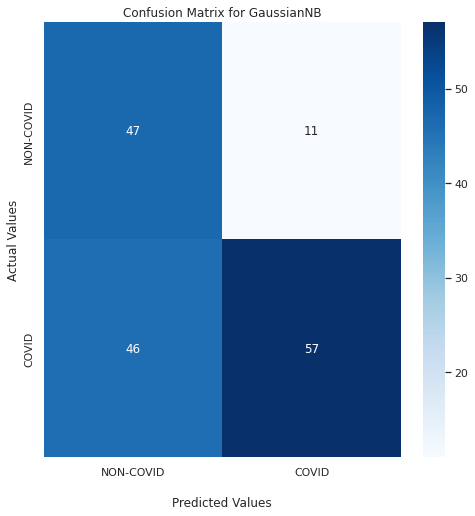

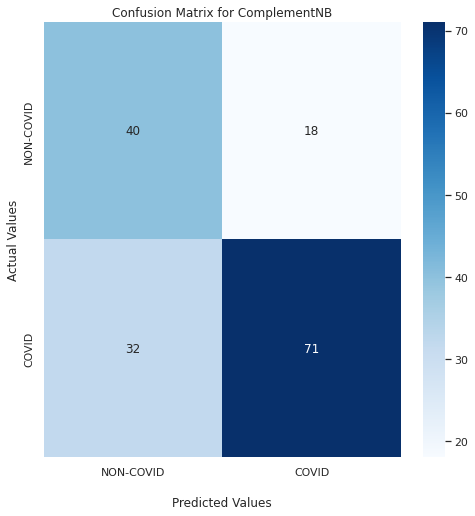

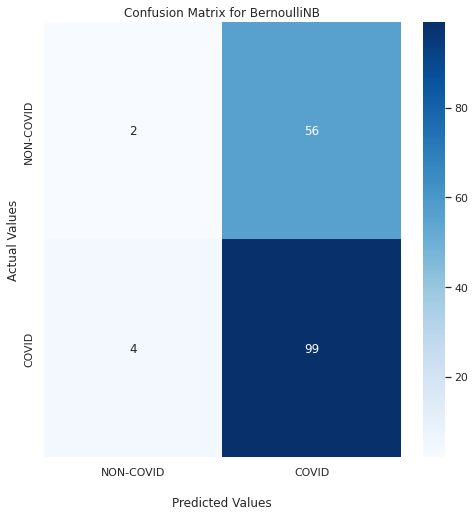

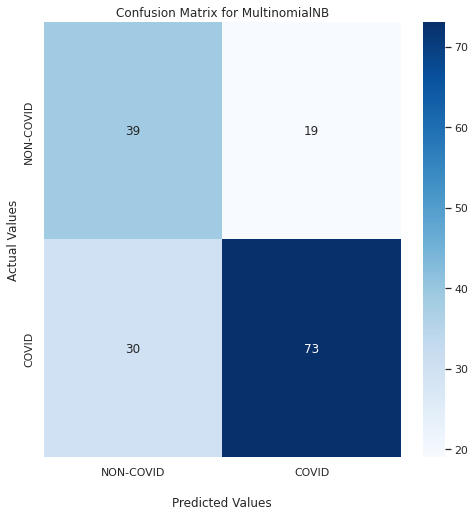

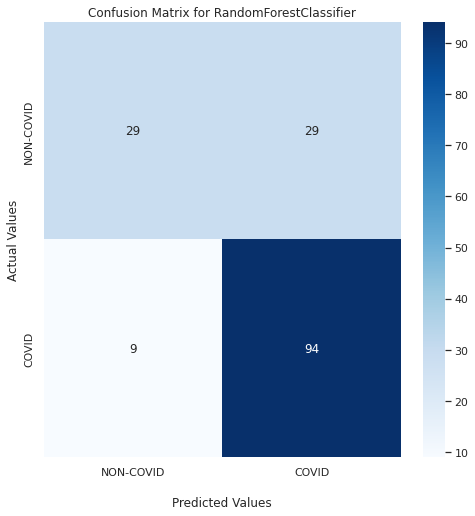

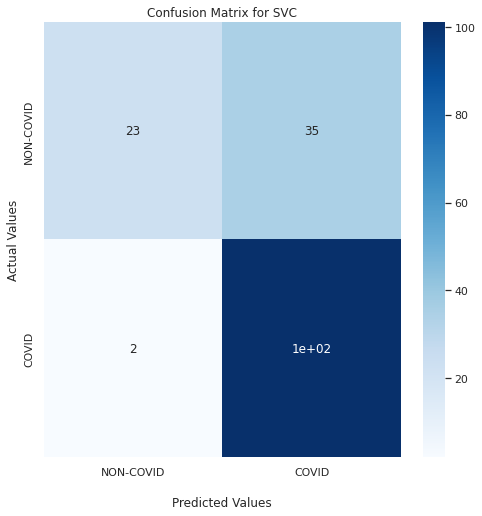

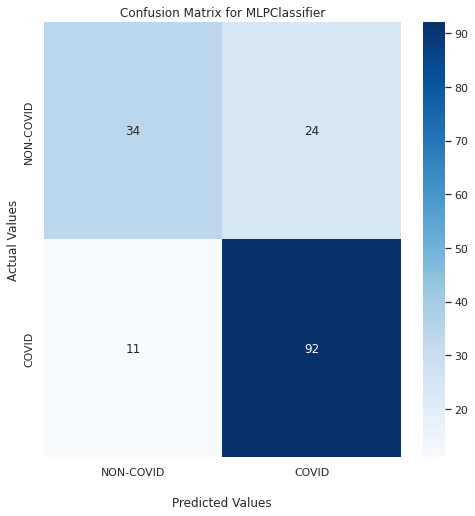

In [ ]:
for i in range(len(model_names)):
  plot_confusion_matrix(confusion_matrices[i], model_names[i])

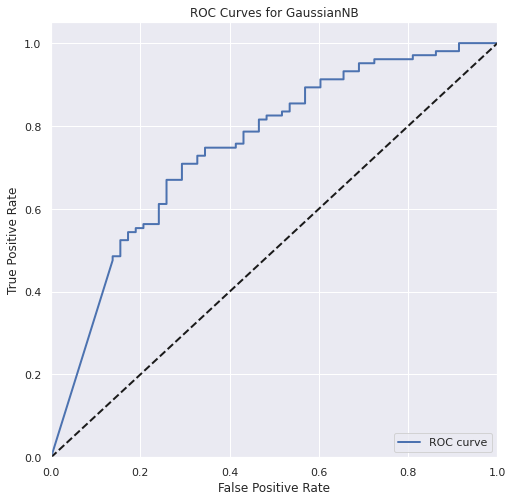

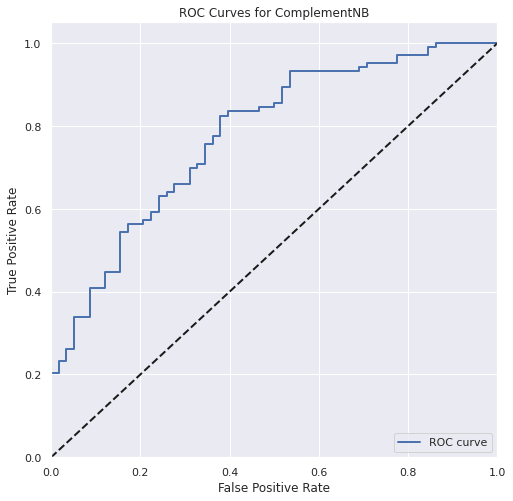

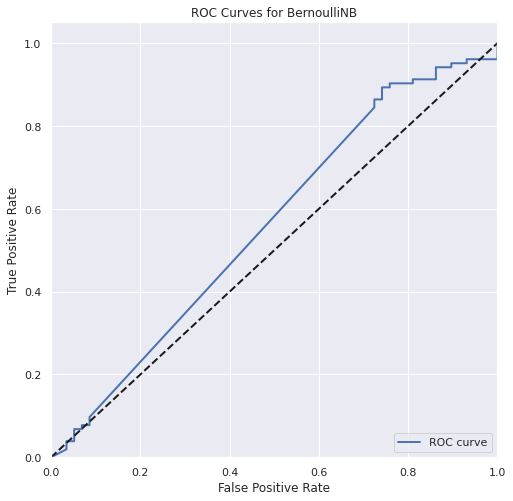

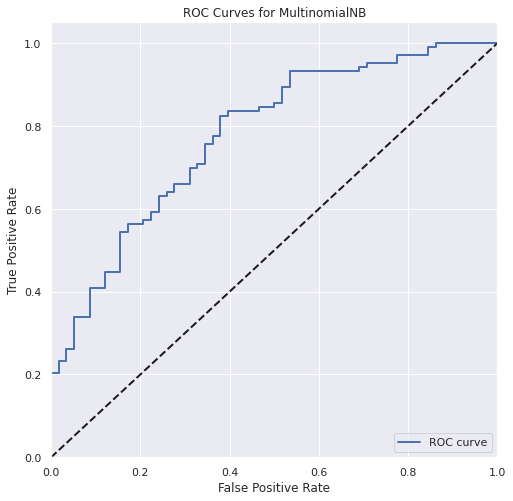

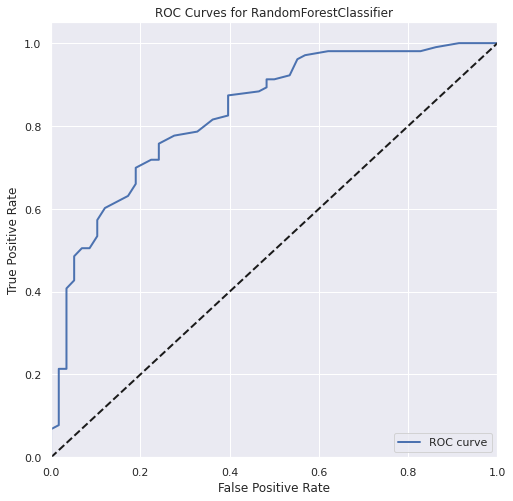

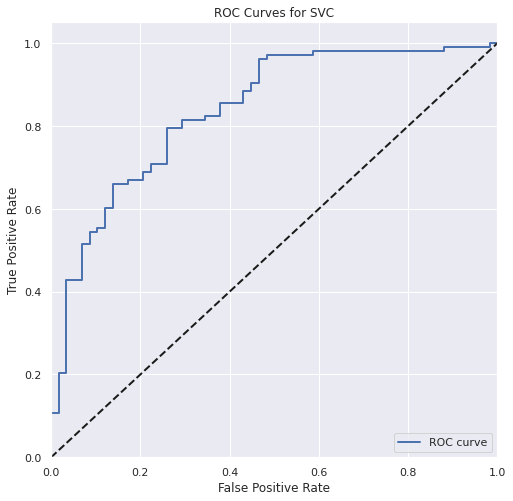

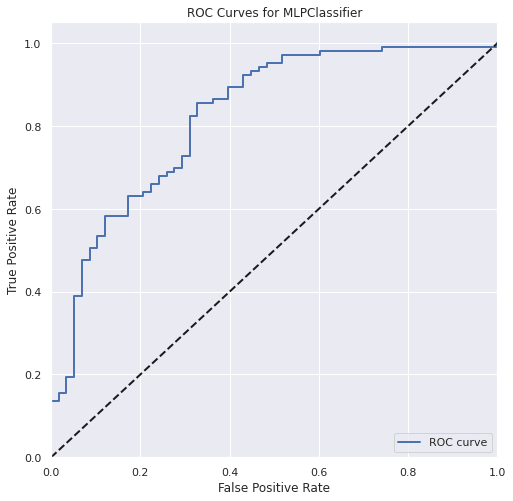

In [ ]:
for i in range(len(models)):
  plot_auc_roc_curve(y_test, predictions_prob[i][:,1], model_names[i])